In [2]:
%pip install -q yfinance pandas pandas-datareader numpy scipy scikit-learn matplotlib

Note: you may need to restart the kernel to use updated packages.


#### config.py

In [132]:
# config.py
ALPHA = 0.99                  # one-tailed confidence
CLOSEOUT_DAYS = 10            # h
ANNUAL_TRADING_DAYS = 252
EQUITY_TICKER = "SPY"         # proxy for S
FRED_RATE_SERIES = ["DGS2"]   # U.S. 2-Year Treasury Constant Maturity rate
WINDOW = 500                  # ~3y of daily data
USE_LED_WOLF = False          # Ledoit–Wolf shrinkage
USE_EWMA = False              # RiskMetrics type
LAMBDA = 0.97                 # EWMA decay
R_SHORT = 0.02                # rate for BS where needed

# Why use DGS2 as a “rates factor”? not SOFR(only in a discounting/valuation layer)
# Curve node, not overnight: For macro/equity factor models you usually want a few tenor nodes (e.g., 2y / 5y / 10y) that represent moves of the yield curve. The 2-year is a classic “policy-sensitive” point—captures expectations about the Fed over the next few years, and co-moves strongly with equities/risk.
# Long history & clean daily series: DGS2 goes back decades with minimal data gaps—good for covariances, stress windows, and regime comparisons.
# Stable mapping to risk (DV01): If you later add bond/IR instruments, DV01s map naturally to moves in 2y/5y/10y nodes.

#### data_loader.py

In [135]:
import numpy as np, pandas as pd, yfinance as yf
from pandas_datareader import data as pdr
from sklearn.covariance import LedoitWolf
# from .config import *
from datetime import datetime, timedelta

def _ewma_cov(dX: np.ndarray, lam: float) -> np.ndarray:
    T, n = dX.shape  # T x n
    mu = np.zeros(n)
    S = np.zeros((n,n))
    w = 1.0
    for t in range(T-1, -1, -1):
        x = dX[t] - mu
        S = lam*S + (1-lam)*np.outer(x, x)  # newer observations get weight (1-lambda)
    return S / (1 - lam**T)  # rescale to be close to sample magnitude

def load_levels_and_cov():
    end = datetime.today()
    start = end - timedelta(days=int(WINDOW*1.6))    
    eq = yf.download(EQUITY_TICKER, start=start, end=end, auto_adjust=True)["Close"]    # Equity
    eq = eq.iloc[:, 0].rename("EQ")
    fred = pdr.DataReader(FRED_RATE_SERIES, "fred", start, end)    # FRED rates (daily %)
    df = pd.concat([eq, fred], axis=1).dropna().tail(WINDOW)
    dS = df["EQ"].diff().dropna()   # ΔX_t
    dr_cols = fred.columns
    dR = df[dr_cols].diff().dropna()
    X = df.loc[dR.index].copy()
    dX = pd.concat([dS.rename("dEQ"), dR], axis=1).dropna()
    M = dX.to_numpy()  # 1-day covariance
    if USE_EWMA:
        Sigma_1d = _ewma_cov(M, LAMBDA)
    else:
        Sigma_1d = np.cov(M, rowvar=False)
    Sigma_h = Sigma_1d * CLOSEOUT_DAYS  # scale to closeout
    levels_today = X.iloc[-1].to_dict()   # Today’s levels for pricing {"EQ": spot S, "DGS2": y%, ...}
    return X, dX, Sigma_h, levels_today

#### greeks.py

In [88]:
import numpy as np
from math import log, sqrt, erf, exp
# from .config import R_SHORT

def N(x): return 0.5*(1+erf(x/np.sqrt(2)))

def bs_call_price(S, K, T, r, sigma):
    if T<=0 or sigma<=0: return max(S-K, 0.0)
    d1 = (log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    d2 = d1 - sigma*sqrt(T)
    return S*N(d1) - K*np.exp(-r*T)*N(d2)

def bs_call_delta(S, K, T, r, sigma):
    if T<=0 or sigma<=0: return 1.0 if S>K else 0.0
    d1 = (log(S/K)+(r+0.5*sigma**2)*T)/(sigma*sqrt(T))
    return N(d1)

def bs_put_delta(S, K, T, r, sigma):
    return bs_call_delta(S,K,T,r,sigma) - 1.0

def equity_delta(n_shares: float) -> float:
    return float(n_shares)

def swap_dv01_to_rate_factor(DV01_dollars: float) -> float:
    return DV01_dollars * 100  # DV01: $/ZWbp; ∂V/∂r_percent (here): $/%. rate factor is "rate level in % points", ∂V/∂r ≈ DV01 * 100

def bond_duration_delta(price: float, duration_yrs: float) -> float:
    # ∂V/∂y ≈ -Duration * Price (per 1.0 change in yield, not bp) → per 1% ≈ -0.01 * Duration * Price
    return -0.01 * duration_yrs * price

#### collateral.py

In [90]:
import numpy as np
# from .greeks import bs_call_price, bs_call_delta

def dstar_stock_per_dollar(S): return np.array([1.0/S, 0.0])  # delta per $, equity factor only
def dstar_cash_per_dollar():   return np.array([0.0])

def dstar_call_per_dollar(S, T, r, sigma):
    C = bs_call_price(S,S,T,r,sigma)  # ATM
    Delta = bs_call_delta(S,S,T,r,sigma)  # ATM
    return np.array([Delta/ C, 0.0])   # per-$ delta w.r.t. S

def dstar_rate_bond_per_dollar(delta_per_1pct):  # for rate factor only
    return np.array([delta_per_1pct])   # already per $1

#### risk_engine.py

In [180]:
import numpy as np
# from .config import ALPHA
from scipy.stats import norm

def solve_im(a, b, Sigma):
    q = norm.ppf(ALPHA)
    ab = float(a.T @ Sigma @ b)  # a: D*IM the delta of the normalized portolio D*IM=D_IM/pi_IM(0); b: 
    aa = float(a.T @ Sigma @ a)  # b: D_C=D_U-D_VM, the deltas of the unsecured portfolio netted with the deltas of the VM portfolio
    bb = float(b.T @ Sigma @ b) 
    A = 1.0 - q*q*bb  # coefs for quadratic inequality (equation 2.7) 
    B = 2.0 * q*q * ab
    C = - q*q * aa
    if abs(A) < 1e-5:  # coef of the square term == 0, => linear inequality
        if B <= 0: return None, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
        x = -C/B
        return (x if x>0 else None), None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
    disc = B*B - 4*A*C  # solve the quadratic inequality
    if disc < -1e-5: return None, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
    root = np.sqrt(disc)
    x1, x2 = (-B-root)/(2*A), (-B+root)/(2*A)
    lo, hi = (min(x1,x2), max(x1,x2))
    if A > 0:
        # feasible x<=lo or x>=hi ; we want the smallest positive feasible
        if lo >= 0: return lo, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
        if hi >= 0: return hi, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
        return None, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
    else:
        # feasible between [lo,hi]
        if hi <= 0: return None, None, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}
        return max(0.0, lo), hi, {"A":A,"B":B,"C":C,"bb":bb,"ab":ab,"aa":aa}

def cash_baseline(a, Sigma):
    q = norm.ppf(ALPHA)
    return q * np.sqrt(float(a.T @ Sigma @ a))

#### optimizer.py

In [181]:
import numpy as np
from itertools import product
from scipy.optimize import minimize
# from .risk_engine import solve_im

# Grid and SLSQP to minimize IM over collateral weights (subject to 𝑤≥0,∑𝑤=1w≥0,∑w=1 + feasibility).
def grid_search_min_im(a, Sigma, dstar_list, grid=21):
    # dstar_list: [b1, b2, ...] vectors in R^n (per-$ deltas)
    m = len(dstar_list)
    best = (np.inf, None, None)
    for weights in product(np.linspace(0,1,grid), repeat=m):
        w = np.array(weights); w /= w.sum() if w.sum()>0 else 1.0
        b = np.sum([w[i]*dstar_list[i] for i in range(m)], axis=0)
        lo, hi, meta = solve_im(a, b, Sigma)
        if lo is not None and lo < best[0]: best = (lo, w, (hi, meta))
    return best  # (min_IM, weights, (upper_bound, diagnostics))
# Pros: simple, deterministic, can find near-global min if the grid is fine.
# Cons: explodes combinatorially (grid^m), so it’s slow for large m or finer grids; only coarse resolution.

def slsqp_min_im(a, Sigma, dstar_list):
    m = len(dstar_list)
    x0 = np.ones(m)/m
    cons = [{"type":"eq","fun":lambda w: np.sum(w)-1.0}]
    bnds = [(0,1)]*m
    def obj(w):
        b = sum(w[i]*dstar_list[i] for i in range(m))
        lo, hi, meta = solve_im(a, b, Sigma)
        return lo if lo is not None else 1e9
    res = minimize(obj, x0, bounds=bnds, constraints=cons, method="SLSQP", options={"maxiter":200})
    w = res.x
    b = sum(w[i]*dstar_list[i] for i in range(m))
    lo, hi, meta = solve_im(a, b, Sigma)
    return lo, w, (hi, meta, res.success)
# Pros: fast; scales to larger m; respects constraints exactly.
# Cons: can get stuck in local minima; requires obj(w) to be reasonably smooth for best results; depends on starting point.

#### validation.py

In [182]:
import numpy as np, matplotlib.pyplot as plt
from scipy.stats import norm
# from .risk_engine import solve_im, cash_baseline
    
def scenario_curve_vol(a, Sigma_scalar, S, K, T, r, U0, vols):
    q = norm.ppf(0.99)
    imr_cash, stock_lo, stock_hi, call_lo, call_hi = [],[],[],[],[]
    for vol in vols:
        Sigma = np.array([[ (vol**2) * Sigma_scalar, 0.0], [0.0, 0.0]])
        b_stock = np.array([1.0/ S, 0.0])
        C = bs_call_price(S, K, T, r, vol)
        Delta = bs_call_delta(S, K, T, r, vol)
        b_call = np.array([Delta / C, 0.0])  # per-$ delta at this σ
        imr_cash.append(cash_baseline(a, Sigma)/U0)
        lo, hi, _ = solve_im(a, b_stock, Sigma); stock_lo.append(lo/U0 if lo else np.nan); stock_hi.append(hi/U0 if hi else np.nan)
        lo, hi, _ = solve_im(a, b_call,  Sigma); call_lo.append(lo/U0 if lo else np.nan);  call_hi.append(hi/U0 if hi else np.nan)
    return np.array(imr_cash), np.array(stock_lo), np.array(stock_hi), np.array(call_lo), np.array(call_hi)

def plot_imr_vs_vol(vols, imr_cash, stock_lo, stock_hi, call_lo, call_hi):
    plt.figure(figsize=(8,5))
    plt.plot(100*vols, 100*stock_lo,  'o-', label="IMR_lower (stock)")
    plt.plot(100*vols, 100*stock_hi,  's-', label="IMR_upper (stock)")
    plt.plot(100*vols, 100*call_lo,   '^-', label="IMR_lower (call)")
    plt.plot(100*vols, 100*call_hi,   'x-', label="IMR_upper (call)")
    plt.plot(100*vols, 100*imr_cash,  '*-', label="IMR (cash)")
    plt.xlabel("Equity volatility (%)")
    plt.ylabel("IM / unsecured portfolio value (%)")
    plt.title("IM requirement vs equity volatility")
    plt.legend(); plt.tight_layout(); plt.show()


#### backtest.py

In [183]:
import numpy as np, pandas as pd
# from .risk_engine import cash_baseline, solve_im

def backtest_exceedances(dX_df, a, b, Sigma_h, alpha=0.99):
    # simple check: simulate linear loss L = a^T ΔX over 10-day sums (or use 10-day rolling sums)
    # ΔX is 1-day; build 10-day blocks:
    M = dX_df.to_numpy()
    h = 10
    blocks = [M[i:i+h].sum(axis=0) for i in range(0, len(M)-h)]
    losses = np.array([a @ blk for blk in blocks])  # linearized exposure
    # model IM (constant over the period for demo)
    lo, hi, meta = solve_im(a, b, Sigma_h)
    threshold = lo if lo is not None else np.nan
    exc = np.mean(losses > threshold)
    return {"im_level": threshold, "exc_rate": exc, "n": len(losses)}

#### stress.py

In [184]:
import numpy as np
def scale_sigma(Sigma, scale): return Sigma * (scale**2)
def rotate_2d(vec, theta):     # rotate a 2D vector by theta (radians)
    c,s = np.cos(theta), np.sin(theta)  # sweep direction of a shock across the plane spanned by two correlated factors.
    R = np.array([[c,-s],[s,c]])
    return R @ vec

#### scenario_table2.py

In [185]:
import numpy as np, pandas as pd
# from .config import R_SHORT
# from .greeks import bs_call_price, bs_call_delta, equity_delta, bs_put_delta, swap_dv01_to_rate_factor, bond_duration_delta
# from .risk_engine import solve_im, cash_baseline

def build_table2(S, vol, r_level, Sigma_h):
    # One-factor equity case for options; add one rate factor for swaps/bond
    # Define unsecured portfolio deltas a for each row/col label:
    labels = ["Stock","Call","Put", "Bond","Cash"]

    # unsecured value π_U(0) for IM ratio denominator (by convention we use |MTM| where needed)
    def unsecured_value(lbl):
        if lbl=="Stock":  return S
        if lbl=="Call":   return bs_call_price(S,S,0.25,r_level,vol)
        if lbl=="Put":    return bs_call_price(S,S,0.25,r_level,vol)  # ATM call price is used in paper; for put, you can use put price too
        # if lbl=="Pay":    return 10000.0  # MTM assumption from paper’s table
        # if lbl=="Rec":    return 10000.0
        if lbl=="Bond":   return 1000.0
        if lbl=="Cash":   return 1.0
        return 1.0

    def unsecured_delta(lbl):
        # Return a vector in R^n. use n=2 (equity level, single rate node) to match the paper’s setup
        if lbl=="Stock":  return np.array([1.0, 0.0])
        if lbl=="Call":   return np.array([bs_call_delta(S,S,0.25,r_level,vol), 0.0])
        if lbl=="Put":    return np.array([bs_put_delta (S,S,0.25,r_level,vol), 0.0])
        # if lbl=="Pay":    return np.array([0.0, swap_dv01_to_rate_factor(5000.0)])   # DV01 $5000
        # if lbl=="Rec":    return np.array([0.0,-swap_dv01_to_rate_factor(5000.0)])   # opposite sign
        if lbl=="Bond":   return np.array([0.0, bond_duration_delta(1000.0, 15.0)])  # duration 15y
        if lbl=="Cash":   return np.array([0.0, 0.0])
        return np.zeros(2)

    def im_per_dollar(lbl):
        if lbl=="Stock": return np.array([1.0/S, 0.0])
        if lbl=="Call":
            C = bs_call_price(S,S,0.25,r_level,vol)
            Delta = bs_call_delta(S,S,0.25,r_level,vol)
            return np.array([Delta/C, 0.0])
        if lbl=="Put":
            # per-$ delta of put collateral (rare in practice); symmetric to call
            C = bs_call_price(S,S,0.25,r_level,vol)
            Delta = bs_put_delta(S,S,0.25,r_level,vol)
            return np.array([Delta/C, 0.0])
        # if lbl=="Pay":  return np.array([0.0,  swap_dv01_to_rate_factor(5000.0)/10000.0])  # per-$  (units: per $1)
        # if lbl=="Rec":  return np.array([0.0, -swap_dv01_to_rate_factor(5000.0)/10000.0])
        if lbl=="Bond": return np.array([0.0,  bond_duration_delta(1000.0,15.0)/1000.0])
        if lbl=="Cash": return np.array([0.0, 0.0])
        return np.zeros(2)

    tbl = pd.DataFrame(index=labels, columns=labels, dtype=float)
    for im_lbl in labels:
        b = im_per_dollar(im_lbl)
        for up_lbl in labels:
            a = unsecured_delta(up_lbl)   # D_U (assume D_VM=0)
            U0 = unsecured_value(up_lbl)
            lo, hi, _ = solve_im(a, b, Sigma_h)
            if lo is None:
                tbl.loc[im_lbl, up_lbl] = np.nan
            else:
                tbl.loc[im_lbl, up_lbl] = 100.0 * (lo / U0)   # IMR in %
    return tbl


#### main.py

[*********************100%***********************]  1 of 1 completed



--- Table 2 style IMR matrix (%, NA where infeasible) ---

       Stock   Call    Put  Bond  Cash
Stock   5.73  50.07  47.57  6.92  -0.0
Call    3.97  34.69  95.27  8.80  -0.0
Put    10.99  95.99  30.88  7.16  -0.0
Bond    6.15  53.73  44.37  6.41  -0.0
Cash    6.08  53.11  44.67  6.85  -0.0


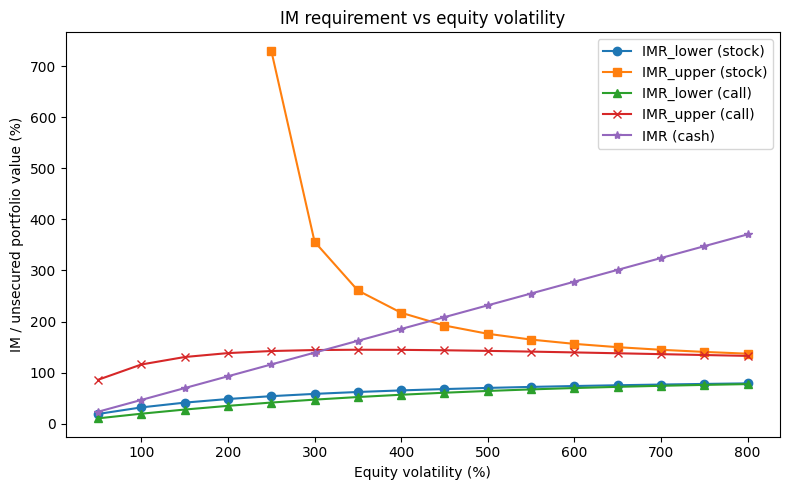

In [186]:
# from .data_loader import load_levels_and_cov
# from .scenario_table2 import build_table2
# from .validation import scenario_curve_vol, plot_imr_vs_vol
# from .collateral import dstar_stock_per_dollar, dstar_call_per_dollar
import numpy as np, pandas as pd
# from .config import R_SHORT

def run():
    X, dX, Sigma_h, levels = load_levels_and_cov()
    S = float(levels["EQ"])
    r = R_SHORT  # you can also map from levels["DGS2"]/100.0
    # Reproduce Table 2 (the exact numbers will differ because we use real data Σ instead of the paper’s toy Σ)
    tbl2 = build_table2(S, vol=0.30, r_level=r, Sigma_h=Sigma_h)
    print("\n--- Table 2 style IMR matrix (%, NA where infeasible) ---\n")
    print(tbl2.round(2))
    tbl2.to_csv("table2_results.csv")
    # Scenario curve like Fig 2 (single-factor depiction)
    # Build scalars for equity-only illustration
    a = np.array([1.0, 0.0])    # unsecured = 1 share
    Sigma_scalar = (S**2) * (10/252.0)     # baseline scaling; vol^2 multiplies this
    b_stock = dstar_stock_per_dollar(S)
    b_call  = dstar_call_per_dollar(S, T=0.25, r=r, sigma=0.30)
    vols = np.linspace(0.5, 8, 16)
    imr_cash, stock_lo, stock_hi, call_lo, call_hi = scenario_curve_vol(a, Sigma_scalar, S, S, T=0.25, r=r, U0=S, vols=vols)
    plot_imr_vs_vol(vols, imr_cash, stock_lo, stock_hi, call_lo, call_hi)

if __name__ == "__main__":
    run()